# Results Visualizer
This notebook contains a set of summary statistics, visualizations and graphs of the output results, based on the different hypotheses and conducted experiments. The format is as follows:
- Import of required packages and initialization of parameters that are used throughout the notebook
- A section is dedicated for each of the hypotheses of the thesis that contains more information about the hypothesis, the experiments and the respective results, along with visualizations and graphs.

In [1]:
# Imports
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
from notebook_utils import plot_h1_results, plot_h2_results, \
plot_h3_results, plot_h3_results_mixed, plot_results_with_std_1, \
plot_results_with_std_2
# matplotlib params
plt.rcParams.update({
    'font.size': 18,
    'lines.linewidth': 4,
    'axes.titlesize': 20,
    'figure.titlesize': 24
})
w0 = 3 # initial width
h0 = 3 # initial height
# save figures flag and directory
save_figures = False
figures_dir = 'saved'

## Metadata
In the output directory of each experiment, there is `metadata.csv` file that stores the configuration of the individual runs for each experiment:
- **dataset_name**: the name of the dataset
- **dataset_iter**: specific train/test split of the dataset used
- **search_type**: `'default'`, `'random', 'ue' or 'smac'`
- **validation_strategy**: `stratified` or `balanced`
- **validation_size**: `20`, `50`, `100`, `200` or `400`
- **total_budget**: total budget in seconds
- **per_run_budget**: budget per individual run in seconds

From these values, the aggregated experiment parameters are calculated and passed later on to the plotting function for each hypothesis.

In [2]:
# Output directories
results_dirname = '../results/sp1' # parent directory string
results_path = os.path.join(Path.cwd(), results_dirname) # parent directory path
cv_results_path = os.path.join(results_path, 'cv_results') # cv_results path
performance_path = os.path.join(results_path, 'performance') # performance path
results_processed_path = os.path.join(results_path, 'processed') # processed path
# Import metadata
metadata_filepath = os.path.join(results_path, 'metadata.csv') # metadata.csv path
metadata_df = pd.read_csv(metadata_filepath) # metadata dataframe
# Remove subroutine random search runs (part of uniform exploration)
metadata_df = metadata_df[metadata_df['total_budget'] != 30]
# Extract experiment parameters
total_budget = metadata_df.total_budget[0]
dataset_list = list(metadata_df.dataset_name.unique())
search_algorithm_list = list(metadata_df.search_type.unique())
validation_strategy_list = list(metadata_df.validation_strategy.unique())
validation_size_list = list(metadata_df.validation_size.unique())
# Print the parameters
print('Dataset list:\t\t\t\t', dataset_list)
print('Search algorithm list:\t\t\t', search_algorithm_list)
print('Validation set split strategy list:\t', validation_strategy_list)
print('Validation set size list:\t\t', validation_size_list)
print('Total budget (seconds):\t\t\t', total_budget)

Dataset list:				 ['ALOI', 'Annthyroid', 'Arrhythmia', 'Cardiotocography', 'SpamBase', 'Waveform']
Search algorithm list:			 ['ue', 'random', 'smac', 'default']
Validation set split strategy list:	 ['stratified', 'balanced']
Validation set size list:		 [20, 50, 100, 200]
Total budget (seconds):			 600


## PART 1 - Performance Summary
### 1.1 - Performance Summary per Dataset
This section parses the processed results for each dataset and prints the best optimization and test scores along with the parameters that achieved them:
- Search strategy
- Validation set split strategy
- Validation set size

In [3]:
# Performance per dataset
for dataset in dataset_list:
    best_opt_score = 0.0
    best_test_score = 0.0
    best_opt_params = None
    best_test_params = None
    for filename in os.listdir(results_processed_path):
        if dataset in filename:
            # import performance data as DataFrame
            df = pd.read_csv(
                os.path.join(
                    results_processed_path, filename),
            )
            # optimization score
            if df['single_best_optimization_score'].iloc[-1] > best_opt_score:
                best_opt_score = df['single_best_optimization_score'].iloc[-1]
                best_opt_params = filename.split('.')[0].split('_')[1:]
            # test score
            # Comment in/out according to the desired results
            if df['single_best_test_score'].iloc[-1] > best_test_score:
                best_test_score = df['single_best_test_score'].iloc[-1]
                best_test_params = filename.split('.')[0].split('_')[1:]
    print('\033[1m',dataset,'\033[0m')
    print('  Validation ({}, {})'.format(best_opt_score, best_opt_params))
    print('  Test\t     ({}, {})\n'.format(best_test_score, best_test_params))
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -')

 ALOI 
  Validation (0.9578947368421054, ['random', 'stratified', '20'])
  Test	     (0.7147302051888678, ['random', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 Annthyroid 
  Validation (0.9444444444444444, ['random', 'stratified', '20'])
  Test	     (0.7243458646616542, ['ue', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 Arrhythmia 
  Validation (0.916, ['ue', 'balanced', '20'])
  Test	     (0.7760088272383354, ['ue', 'balanced', '100'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 Cardiotocography 
  Validation (0.890625, ['ue', 'stratified', '20'])
  Test	     (0.7670566757945398, ['ue', 'balanced', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 SpamBase 
  Validation (0.8109999999999999, ['smac', 'balanced', '20'])
  Test	     (0.6950094183242916, ['ue', 'stratified', '200'])

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
 Waveform 
  Validation

### 1.2 - Performance Summary per Dataset-Search Strategy
This section parses the processed results for each dataset and and search strategy and prints the best optimization and test scores along with the parameters that achieved them:
 - Validation set split strategy
 - Validation set size

In [4]:
# Performance per (dataset, search strategy) tuples
validation_set_size = '100'
validation_set_strategy = 'balanced'
search_strategy_list = ['default', 'random', 'ue', 'smac']
np_matrix = np.zeros((len(dataset_list), 4)) # number of search strategies = 4
for i, dataset in enumerate(dataset_list):
    #print(dataset)
    for j, search in enumerate(search_strategy_list):
        best_opt_score = 0.0
        best_test_score = 0.0
        best_opt_params = None
        best_test_params = None
        for filename in os.listdir(results_processed_path):
            if dataset in filename \
            and search in filename \
            and validation_set_size in filename \
            and validation_set_strategy in filename:
                # import performance data as DataFrame
                df = pd.read_csv(
                    os.path.join(
                        results_processed_path, filename),
                )
                # optimization score
                if df['single_best_optimization_score'].iloc[-1] > best_opt_score:
                    best_opt_score = round(df['single_best_optimization_score'].iloc[-1], 3)
                    best_opt_params = filename.split('.')[0].split('_')[2:]
                # test scores
                # Comment in/out according to the desired results
                #if df['single_best_test_score'].iloc[-1] > best_test_score:
                    best_test_score = round(df['single_best_test_score'].iloc[-1], 3)
                    best_test_params = filename.split('.')[0].split('_')[2:]
        np_matrix[i][j] = best_test_score
# construct pd matrix
matrix = pd.DataFrame(
    np_matrix, 
    columns=search_strategy_list, 
    index=dataset_list
)
matrix

,default,random,ue,smac
ALOI,0.600,0.711,0.698,0.665
Annthyroid,0.705,0.680,0.713,0.696
Arrhythmia,0.733,0.720,0.776,0.748
Cardiotocography,0.713,0.746,0.752,0.760
SpamBase,0.679,0.674,0.692,0.688
Waveform,0.737,0.752,0.791,0.770


### 1.3 - Statistical Comparison of Search Strategies
This section conducts a non-parametric Friedman test to assess the significance of difference in average performance of N different search strategies on M datasets.

In [5]:
# Statistical comparison of search strategies
# Add ML-stats directory to sys
import os, sys
p = os.path.abspath('../ML-stats')
sys.path.insert(1, p)
# Imports
from src.classifier_comparisons import BlockDesign
from src.multiple_classifiers import friedman_test
from src.multiple_classifiers import nemenyi_friedman_test
# Block design
block_design = BlockDesign(matrix, threshold=0.001, precision=3, higher_is_better=True)
# Friedman test
test_results = friedman_test(block_design, alpha=0.05)
print(test_results)
print(block_design.to_ranks())

Number of compared methods: 4
Number of datasets: 6
Number of compared methods: 4
Number of datasets: 6
               alpha critical value test statistic   p value  \
Friedman test   0.05       7.814728            9.4  0.024419   
Iman Davenport  0.05       3.287382       5.465116  0.009676   

               significant? (test stat > crit value)  
Friedman test                                   True  
Iman Davenport                                  True  
Number of compared methods: 4
Number of datasets: 6
         average rank  standard deviation
default      3.333333            0.745356
random       3.166667            1.067187
ue           1.333333            0.471405
smac         2.166667            0.687184


### 1.4 - Factor Analysis using Linear Regression
Applying linear regression to predict ROC AUC given the parameters:
- Dataset
- Search strategy
- Validation set split strategy
- Validation set size

R2 all:				 0.8044782463954239
R2 without dataset:		 0.1862747867085438
R2 without search strategy:	 0.6868593052563317
R2 without validation strategy:	 0.7803937474661655
R2 without validation size:	 0.7417332384134165


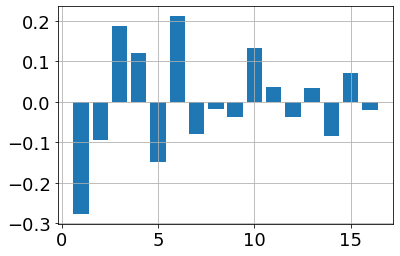

ALOI: 		-0.27675605317232366
Annthyroid: 		-0.09306109725623145
Arrhythmia: 		0.1868850445318828
Cardiotocography: 		0.12022843568732654
SpamBase: 		-0.1489131321936433
Waveform: 		0.21161680240298894
default: 		-0.07836633536061073
random: 		-0.017436113664718124
smac: 		-0.036567936132300444
ue: 		0.13237038515762942
balanced: 		0.03608726258917605
stratified: 		-0.03608726258917608
100: 		0.034522527808190505
20: 		-0.08442464188171915
200: 		0.0704330527555999
50: 		-0.020530938682071145


In [6]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
# examples matrix
factor_matrix = []
# loop over possible combinations of parameters and find best test score
for dataset in dataset_list:
    for search_strategy in search_algorithm_list:
        for validation_strategy in validation_strategy_list:
            for validation_size in validation_size_list:
                filename = '_'.join([dataset, search_strategy, validation_strategy, str(validation_size)])+'.csv'
                if filename in os.listdir(results_processed_path):
                    df = pd.read_csv(os.path.join(results_processed_path, filename))
                    valid_auc = df.tail(1)['single_best_optimization_score'].values[0]
                    test_auc = df.tail(1)['single_best_test_score'].values[0]
                    factor_matrix.append([dataset, search_strategy, validation_strategy, str(validation_size), valid_auc, test_auc])
# convert to DataFrame
factor_df = pd.DataFrame(factor_matrix, columns=[
    'dataset',
    'search_strategy',
    'validation_strategy',
    'validation_size',
    'valid_auc',
    'test_auc'])
# Extract features/targets
features_all = factor_df[['dataset', 'search_strategy', 'validation_strategy', 'validation_size']]
features_wo_dataset = factor_df[['search_strategy', 'validation_strategy', 'validation_size']]
features_wo_search_strategy = factor_df[['dataset', 'validation_strategy', 'validation_size']]
features_wo_validation_strategy = factor_df[['dataset', 'search_strategy', 'validation_size']]
features_wo_validation_size = factor_df[['dataset', 'search_strategy', 'validation_strategy']]
targets = factor_df['test_auc']
# Preprocess features
enc_all = OneHotEncoder(sparse=False)
enc_wo_dataset = OneHotEncoder(sparse=False)
enc_wo_search_strategy = OneHotEncoder(sparse=False)
enc_wo_validation_strategy = OneHotEncoder(sparse=False)
enc_wo_validation_size = OneHotEncoder(sparse=False)
# fit/transform
features_all = enc_all.fit_transform(features_all)
features_wo_dataset = enc_wo_dataset.fit_transform(features_wo_dataset)
features_wo_search_strategy = enc_wo_search_strategy.fit_transform(features_wo_search_strategy)
features_wo_validation_strategy = enc_wo_validation_strategy.fit_transform(features_wo_validation_strategy)
features_wo_validation_size = enc_wo_validation_size.fit_transform(features_wo_validation_size)
#print('\033[1mCategories:\033[0m\n', enc.categories_)
# Preprocess targets
targets = np.log(targets / (1 - targets)) # logit()
# Define linear regression models
lr_all = LinearRegression()
lr_wo_dataset = LinearRegression()
lr_wo_search_strategy = LinearRegression()
lr_wo_validation_strategy = LinearRegression()
lr_wo_validation_size = LinearRegression()
# fit models
lr_all.fit(features_all, targets)
lr_wo_dataset.fit(features_wo_dataset, targets)
lr_wo_search_strategy.fit(features_wo_search_strategy, targets)
lr_wo_validation_strategy.fit(features_wo_validation_strategy, targets)
lr_wo_validation_size.fit(features_wo_validation_size, targets)
# R2 score
r2_all = lr_all.score(features_all, targets)
r2_wo_dataset = lr_wo_dataset.score(features_wo_dataset, targets)
r2_wo_search_strategy = lr_wo_search_strategy.score(features_wo_search_strategy, targets)
r2_wo_validation_strategy = lr_wo_validation_strategy.score(features_wo_validation_strategy, targets)
r2_wo_validation_size = lr_wo_validation_size.score(features_wo_validation_size, targets)
#
print('R2 all:\t\t\t\t', r2_all)
print('R2 without dataset:\t\t', r2_wo_dataset)
print('R2 without search strategy:\t', r2_wo_search_strategy)
print('R2 without validation strategy:\t', r2_wo_validation_strategy)
print('R2 without validation size:\t', r2_wo_validation_size)
# Plot
plt.bar(range(1,17), height=lr_all.coef_)
plt.grid()
#plt.title('Coefficients of linear regression using all features')
plt.show()
flat_categories = []
for l in enc_all.categories_:
    for i in l:
        flat_categories.append(i)
flat_categories
for i in range(len(flat_categories)):
    print('{}: \t\t{}'.format(flat_categories[i], lr_all.coef_[i]))

### 1.5 - Detailed comparisons
Determine the total comparisons and the winnings of each parameter value for:
 - validation set split strategy
 - validation set size

In [7]:
# Evaluate validation set class prior
wins_balanced = 0
wins_stratified = 0
for dataset in dataset_list:
    for search_strategy in search_algorithm_list:
            for validation_size in validation_size_list:
                filename_balanced = '_'.join([dataset, search_strategy, 'balanced', str(validation_size)])+'.csv'
                filename_stratified = '_'.join([dataset, search_strategy, 'stratified', str(validation_size)])+'.csv'
                if filename_balanced in os.listdir(results_processed_path) and filename_stratified in os.listdir(results_processed_path):
                    # balanced
                    df_balanced = pd.read_csv(os.path.join(results_processed_path, filename_balanced))
                    test_auc_balanced = df_balanced.tail(1)['single_best_test_score'].values[0]
                    # stratified
                    df_stratified = pd.read_csv(os.path.join(results_processed_path, filename_stratified))
                    test_auc_stratified = df_stratified.tail(1)['single_best_test_score'].values[0]
                    if test_auc_stratified >= test_auc_balanced:
                        wins_stratified += 1
                    else:
                        wins_balanced += 1
print('Balanced wins:', wins_balanced)
print('Stratified wins:', wins_stratified)

Balanced wins: 73
Stratified wins: 19


In [8]:
# Evaluate validation set size
# Evaluate balanced vs. stratified
wins_20 = 0
wins_50 = 0
wins_100 = 0
wins_200 = 0
for dataset in dataset_list:
    for search_strategy in search_algorithm_list:
            for validation_strategy in validation_strategy_list:
                filename_20 = '_'.join([dataset, search_strategy, validation_strategy, '20'])+'.csv'
                filename_50 = '_'.join([dataset, search_strategy, validation_strategy, '50'])+'.csv'
                filename_100 = '_'.join([dataset, search_strategy, validation_strategy, '100'])+'.csv'
                filename_200 = '_'.join([dataset, search_strategy, validation_strategy, '200'])+'.csv'
                if filename_20 in os.listdir(results_processed_path) \
                and filename_50 in os.listdir(results_processed_path) \
                and filename_100 in os.listdir(results_processed_path) \
                and filename_200 in os.listdir(results_processed_path):
                    # 20
                    df_20 = pd.read_csv(os.path.join(results_processed_path, filename_20))
                    test_auc_20 = df_20.tail(1)['single_best_test_score'].values[0]
                    # 50
                    df_50 = pd.read_csv(os.path.join(results_processed_path, filename_50))
                    test_auc_50 = df_50.tail(1)['single_best_test_score'].values[0]
                    # 100
                    df_100 = pd.read_csv(os.path.join(results_processed_path, filename_100))
                    test_auc_100 = df_100.tail(1)['single_best_test_score'].values[0]
                    # 200
                    df_200 = pd.read_csv(os.path.join(results_processed_path, filename_200))
                    test_auc_200 = df_200.tail(1)['single_best_test_score'].values[0]
                    if test_auc_20 >= max([test_auc_50, test_auc_100, test_auc_200]):
                        wins_20 += 1
                    elif test_auc_50 >= max([test_auc_20, test_auc_100, test_auc_200]):
                        wins_50 += 1
                    elif test_auc_100 >= max([test_auc_20, test_auc_50, test_auc_200]):
                        wins_100 += 1
                    elif test_auc_200 >= max([test_auc_20, test_auc_50, test_auc_100]):
                        wins_200 += 1
                    else:
                        print('No winner!')
print('20 wins:', wins_20)
print('50 wins:', wins_50)
print('100 wins:', wins_100)
print('200 wins:', wins_200)

20 wins: 0
50 wins: 5
100 wins: 7
200 wins: 32


### Comparison of anomaly detectors
Compares the wins of different anomaly detectors based on criteria such as dataset, search strategy, validation set split strategy and size etc.

In [9]:
# Wins per dataset
for dataset in dataset_list:
    count_cblof = 0
    count_copod = 0
    count_iforest = 0
    count_knn = 0
    count_lof = 0
    count_other = 0
    for filename in os.listdir(cv_results_path):
        # Change the conditions to narrow the search
        if '.csv' in filename and dataset in filename and '100' in filename:
            df = pd.read_csv(os.path.join(cv_results_path, filename))
            winner = df[df['rank_test_scores']==1]['param_classifier:__choice__'].values[0]
            if winner == 'IForestClassifier':
                count_iforest += 1
            elif winner == 'CBLOFClassifier':
                count_cblof += 1
            elif winner == 'COPODClassifier':
                count_copod += 1
            elif winner == 'KNNClassifier':
                count_knn += 1
            elif winner == 'LOFClassifier':
                count_lof += 1
            else:
                count_other += 1
    print('\033[1m',dataset,'\033[0m')
    print('  CBLOF:', count_cblof)
    print('  COPOD:', count_copod)
    print('  IForest:', count_iforest)
    print('  KNN:', count_knn)
    print('  LOF:', count_lof)

 ALOI 
  CBLOF: 10
  COPOD: 3
  IForest: 5
  KNN: 7
  LOF: 35
 Annthyroid 
  CBLOF: 18
  COPOD: 10
  IForest: 4
  KNN: 8
  LOF: 20
 Arrhythmia 
  CBLOF: 8
  COPOD: 4
  IForest: 34
  KNN: 10
  LOF: 4
 Cardiotocography 
  CBLOF: 3
  COPOD: 4
  IForest: 48
  KNN: 4
  LOF: 1
 SpamBase 
  CBLOF: 4
  COPOD: 36
  IForest: 13
  KNN: 5
  LOF: 2
 Waveform 
  CBLOF: 25
  COPOD: 2
  IForest: 17
  KNN: 11
  LOF: 5


## PART 2 - Evaluation of Hypotheses
### 2.1 - H1: Search strategy

**Statement**: *Guided search strategies such as SMAC are expected to perform better than unguided search strategies such as Random Search and Uniform Exploration.*

**Comments**:
- The comparison should be done per dataset.
- The comparison should be done for a specified validation strategy (e.g. stratified) and size (e.g. a percentage 30% of the original training set).

### Generic plotting functions
The plotting functions used in the hypotheses sections. were made generic so the generated plots can depend only on the input arguments:
- **output_performance_path**: path to the `performance` directory
- **dataset_list**: list of datasets used in the experiment
- **total_budget**: total budget in seconds
- **validation_strategy_list**: `['stratified', 'balanced']`
- **validation_size_list**: `[20, 50, 100, 200]`
- **eval_type**: `validation` or `test`
- **plot_color_list**: used for consistent coloring

In [10]:
# Parameters for H1
validation_strategy_h1 = 'balanced'
validation_size_h1 = 100
color_list_h1 = {
    'uniform exploration': 'orange',
    'random search': 'green',
    'SMAC': 'royalblue',
    'default': 'black'
}

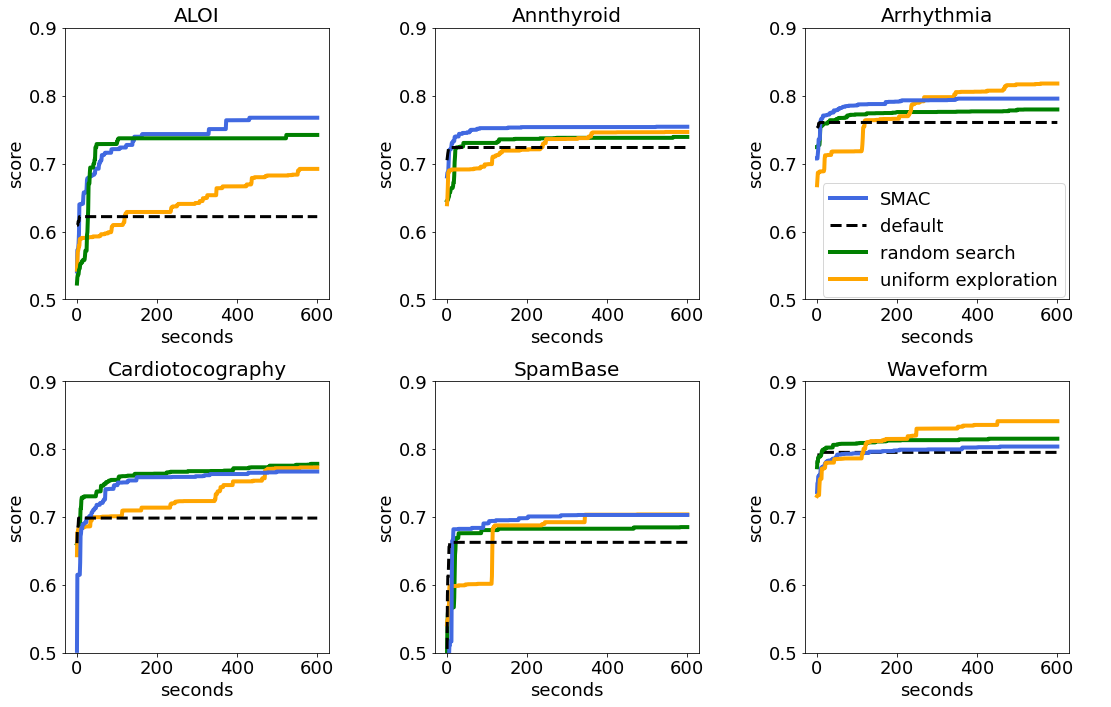

In [11]:
# Plot optimization performance
plot_h1_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h1,
    validation_size_h1,
    'validation',
    color_list_h1,
    [0.5, 0.9]
)

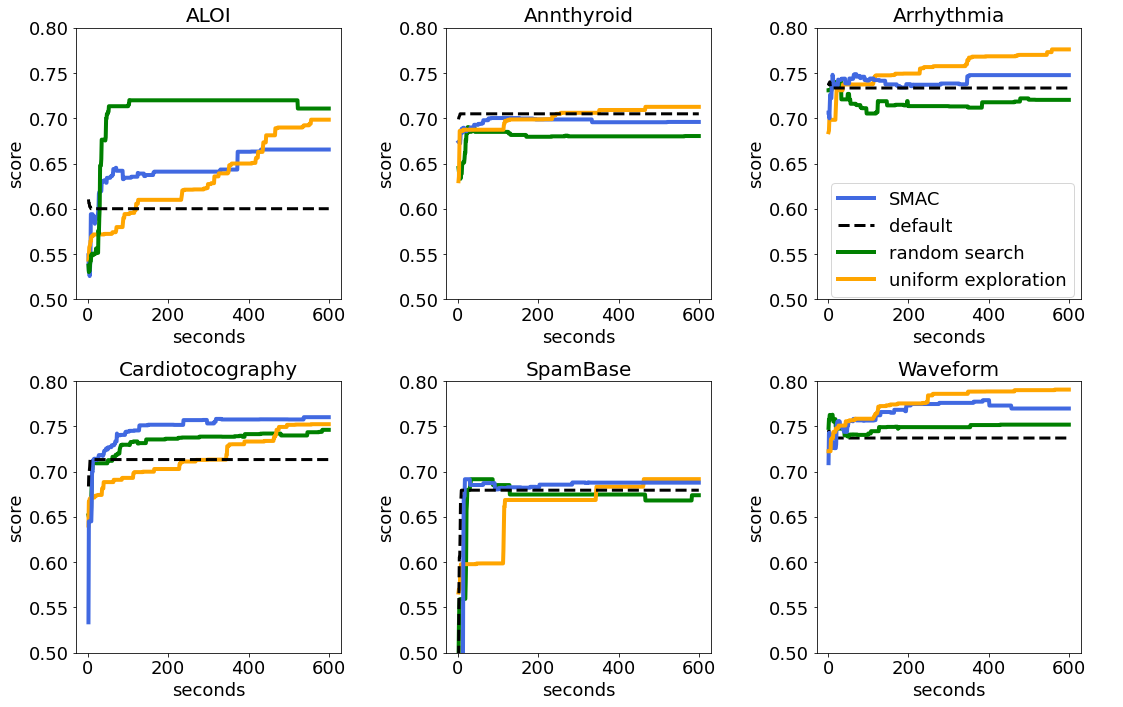

In [12]:
# Plot test set performance
plot_h1_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    total_budget,
    validation_strategy_h1,
    validation_size_h1,
    'test',
    color_list_h1,
    [0.5, 0.8]
)

### 2.2 - H2: Validation set split strategy

**Statement**: *Stratified validation sets are expected to have better performance compared to balanced validation sets.*

**Comments**:
- The expectation of better performance when using stratified validation sets stems from the fact that stratified-sampled validation sets better represent the actual data distribution.
- The comparison should be done per dataset.
- The comparison should be done per search strategy (uniform exploration, random search, smac)
- The comparison should be done for a specified validation set size (e.g. 30% of the original training set).

In [13]:
# Parameters for H2
search_strategy_h2 = 'smac'
validation_size_h2 = 100
color_list_h2 = {
    'stratified': 'orange',
    'balanced': 'green',
}

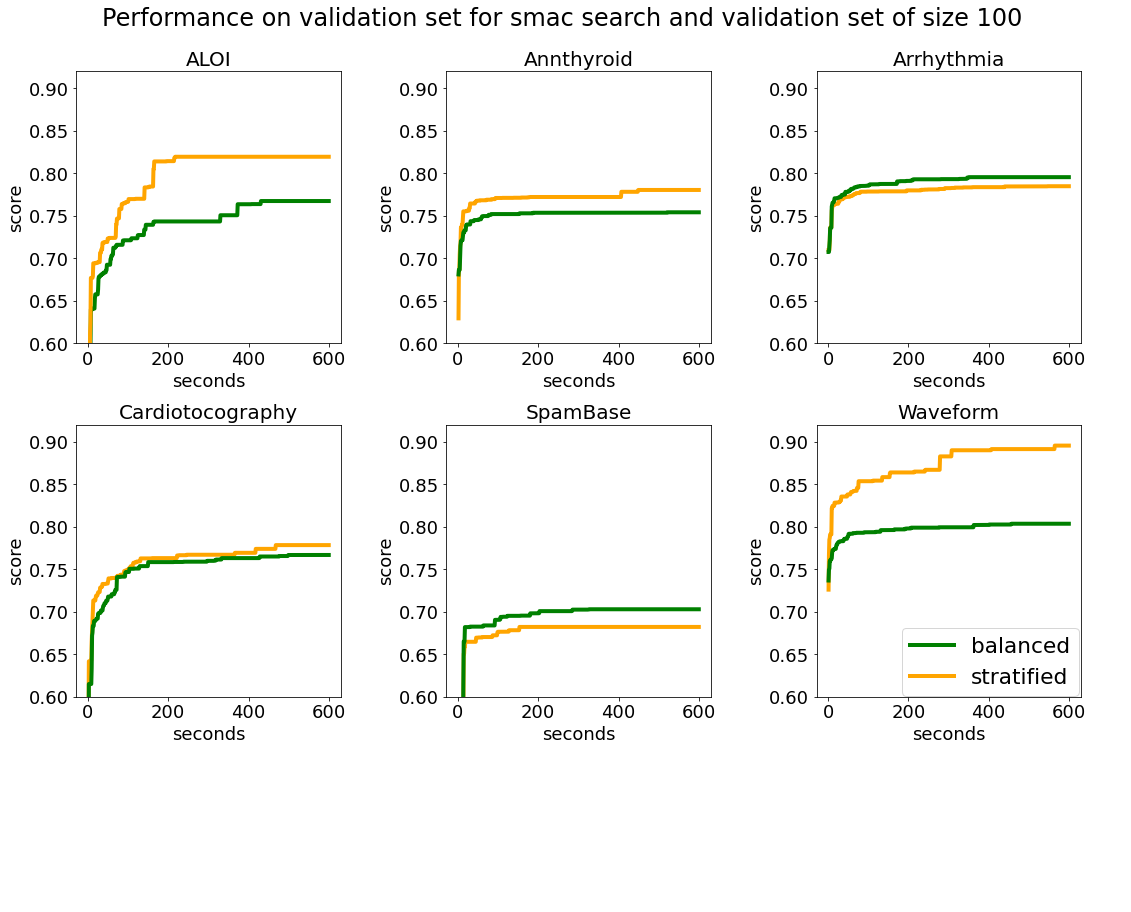

In [14]:
# Plot optimization performance
plot_h2_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    search_strategy_h2,
    total_budget,
    validation_size_h2,
    'validation',
    color_list_h2,
    [0.6, 0.92]
)

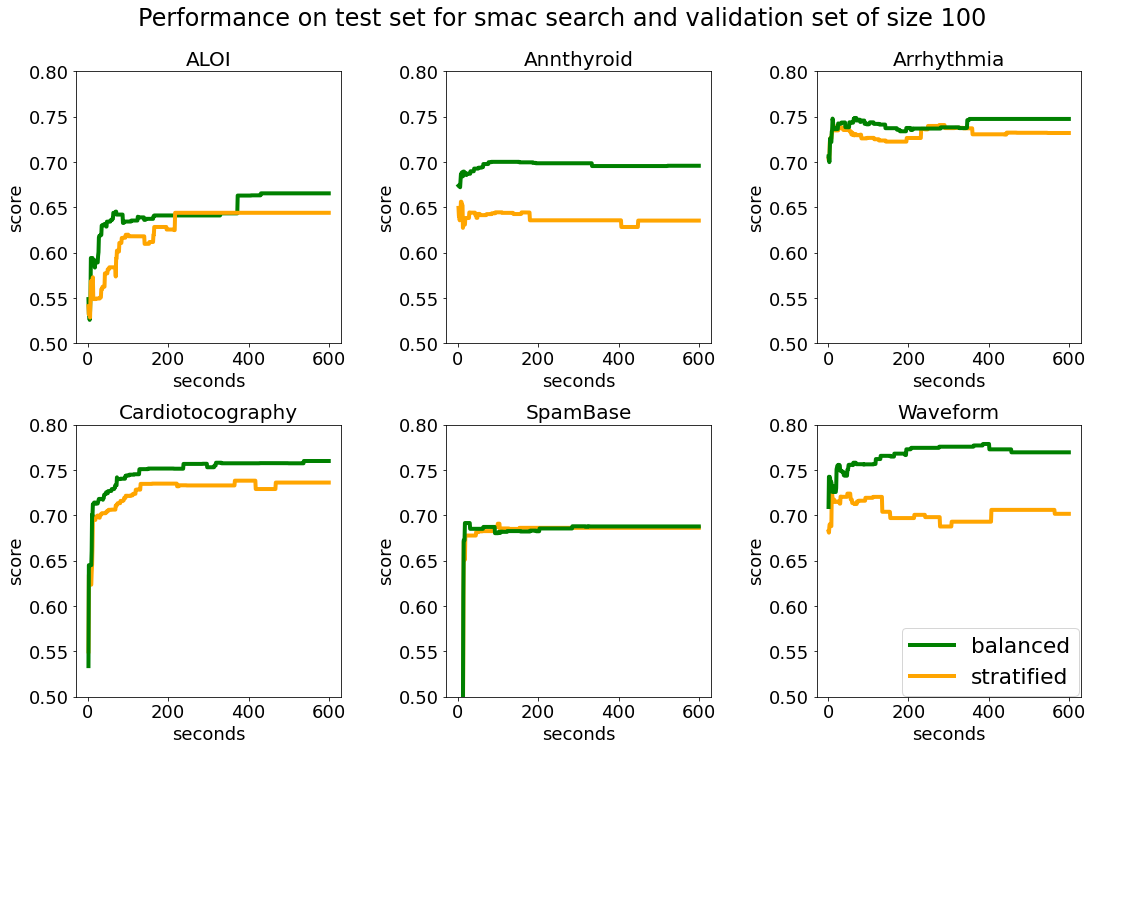

In [15]:
# Plot test set performance
plot_h2_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    search_strategy_h2,
    total_budget,
    validation_size_h2,
    'test',
    color_list_h2,
    [0.5, 0.8]
)

### 2.3 - H3: Validation set size

**Statement**: *Larger validation sets are expected to have better performance compared to smaller validation sets.*

**Comments**:
- Validation set sizes to compare: 20, 50, 100, 200
- Comparison should be done per dataset
- Comparison should be done per search strategy

In [16]:
# Parameters for H3
validation_strategy_h3 = 'balanced'
search_strategy_h3 = 'smac'
color_list_h3 = {
    20: 'red',
    50: 'orange',
    100: 'green',
    200: 'royalblue',
}

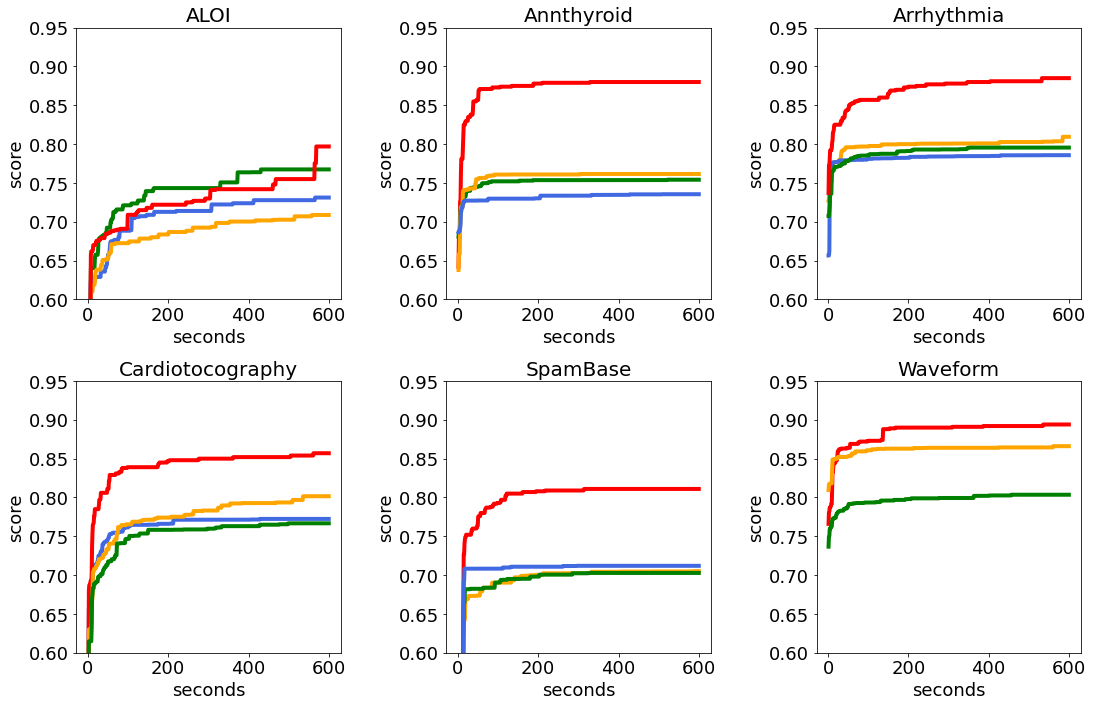

In [17]:
# Plot optimization performance
plot_h3_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    search_strategy_h3,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'validation',
    color_list_h3,
    [0.6, 0.95]
)

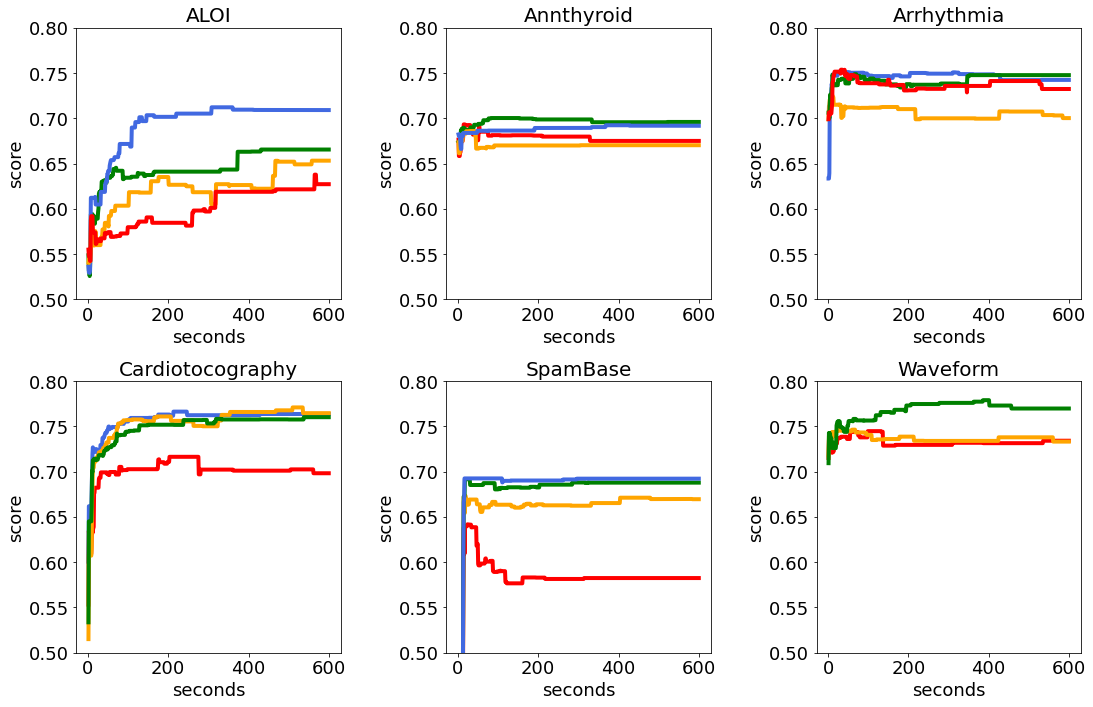

In [18]:
# Plot test set performance
plot_h3_results(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    search_strategy_h3,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    'test',
    color_list_h3,
    [0.5, 0.8]
)

### An alternative presentation of the same results

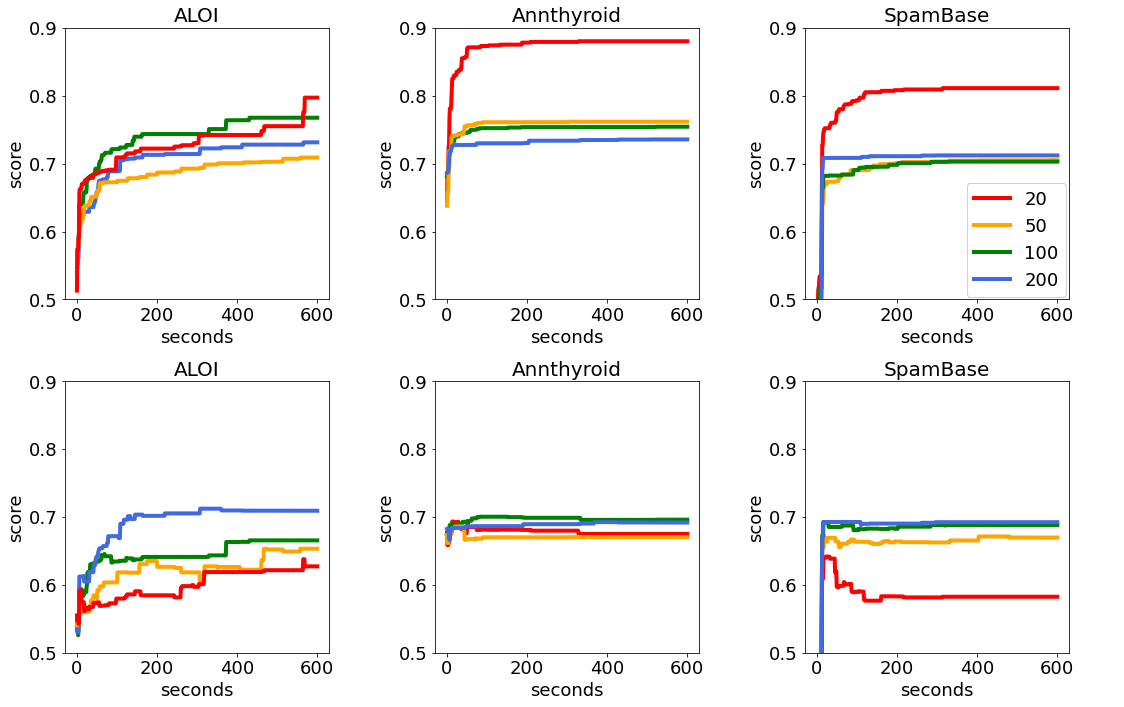

In [19]:
# Plot test set performance
dataset_list_h3 = ['ALOI', 'Annthyroid', 'SpamBase']
plot_h3_results_mixed(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list_h3,
    search_strategy_h3,
    total_budget,
    validation_strategy_h3,
    validation_size_list,
    color_list_h3,
    [0.5, 0.9]
)

## Part 3 - Individual plots with confidence intervals
### 3.1 - Compare performance across datasets for a specified search strategy
This section provides performance plots with standard deviation included, for single runs with well-defined parameters.

In [20]:
# Parameters
search_strategy_31 = 'smac'
validation_strategy_31 = 'balanced'
validation_size_31 = 100

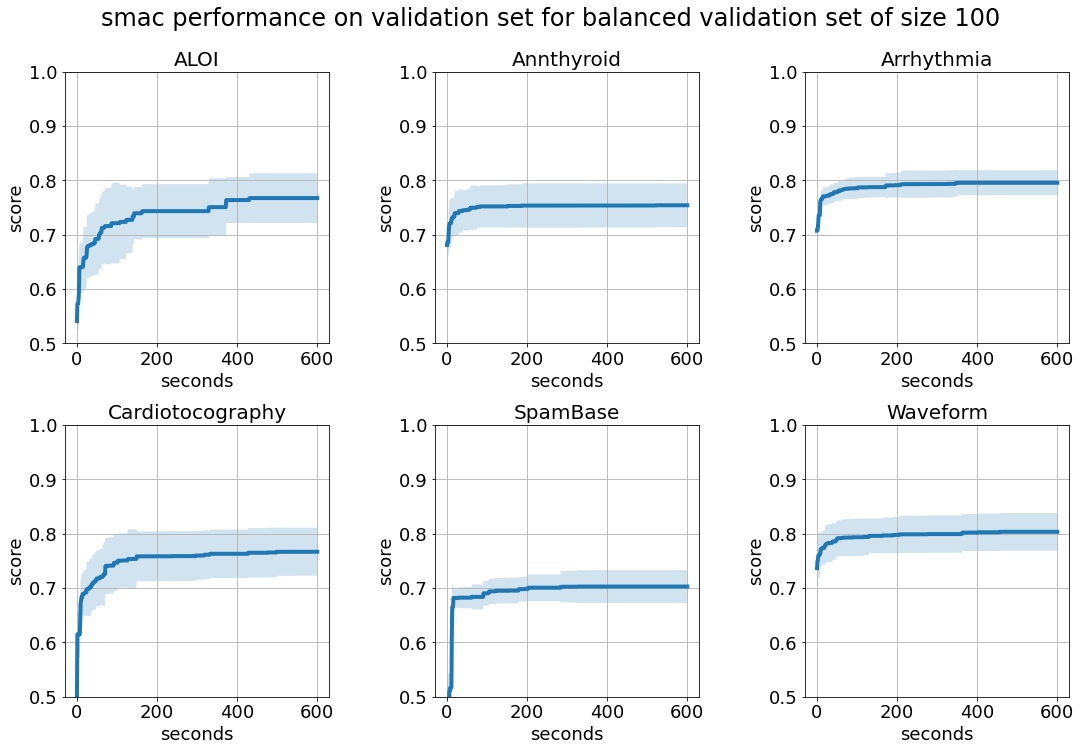

In [21]:
# Plot validation set performance
plot_results_with_std_1(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    total_budget,
    search_strategy_31,
    validation_strategy_31,
    validation_size_31,
    'validation'
)

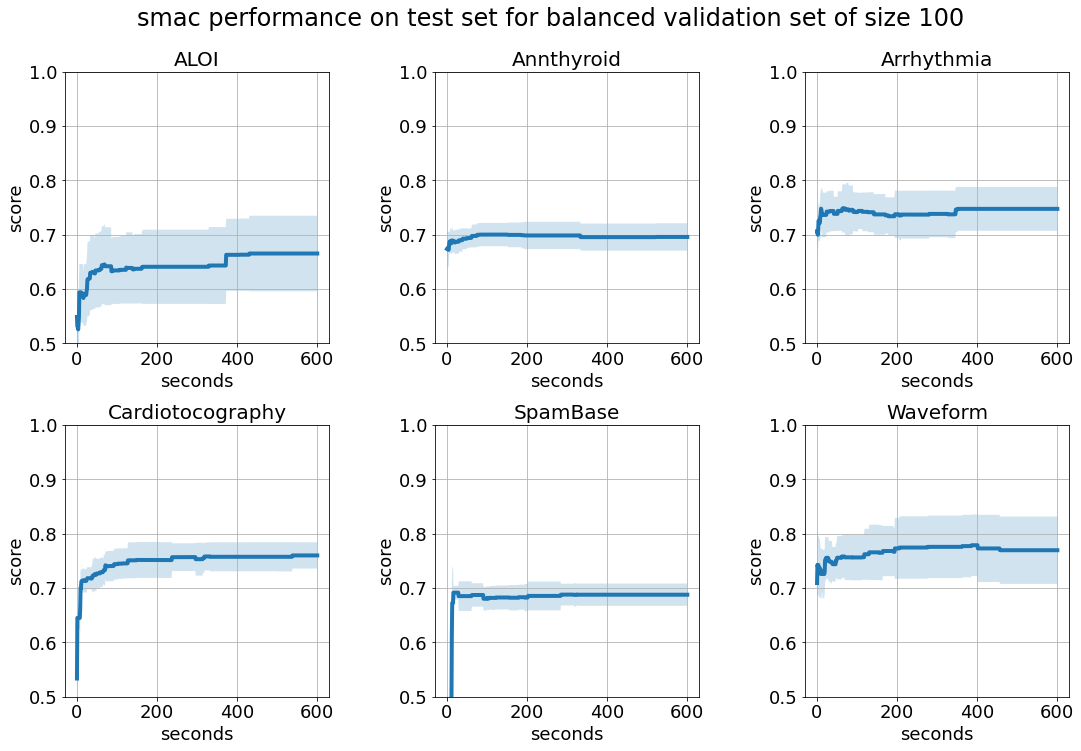

In [22]:
# Plot test set performance
plot_results_with_std_1(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    total_budget,
    search_strategy_31,
    validation_strategy_31,
    validation_size_31,
    'test'
)

### 3.2 - Compare performance across search strategies for a specified dataset
This section compares the scores achieved by the search strategies on the same dataset provided as a parameter

In [23]:
# Parameters for 3.2
dataset_32 = 'Cardiotocography'
validation_strategy_32 = 'balanced'
validation_size_32 = 200

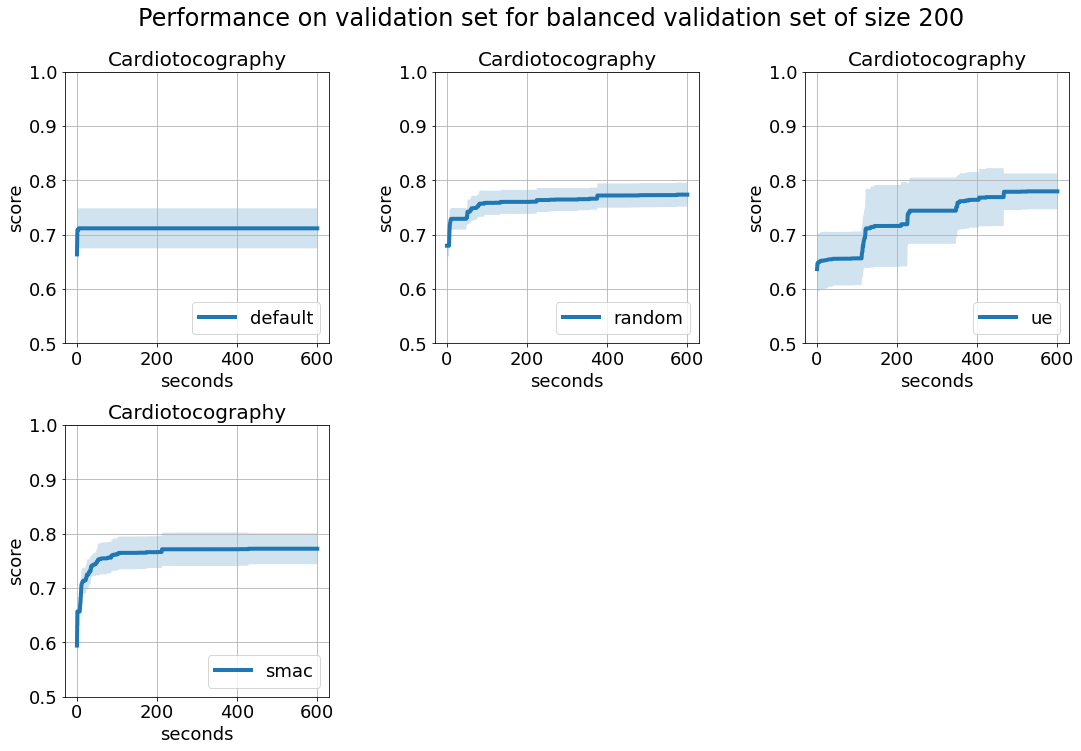

In [26]:
# Plot validation set performance
plot_results_with_std_2(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    dataset_32,
    total_budget,
    search_strategy_list,
    validation_strategy_32,
    validation_size_32,
    'validation'
)

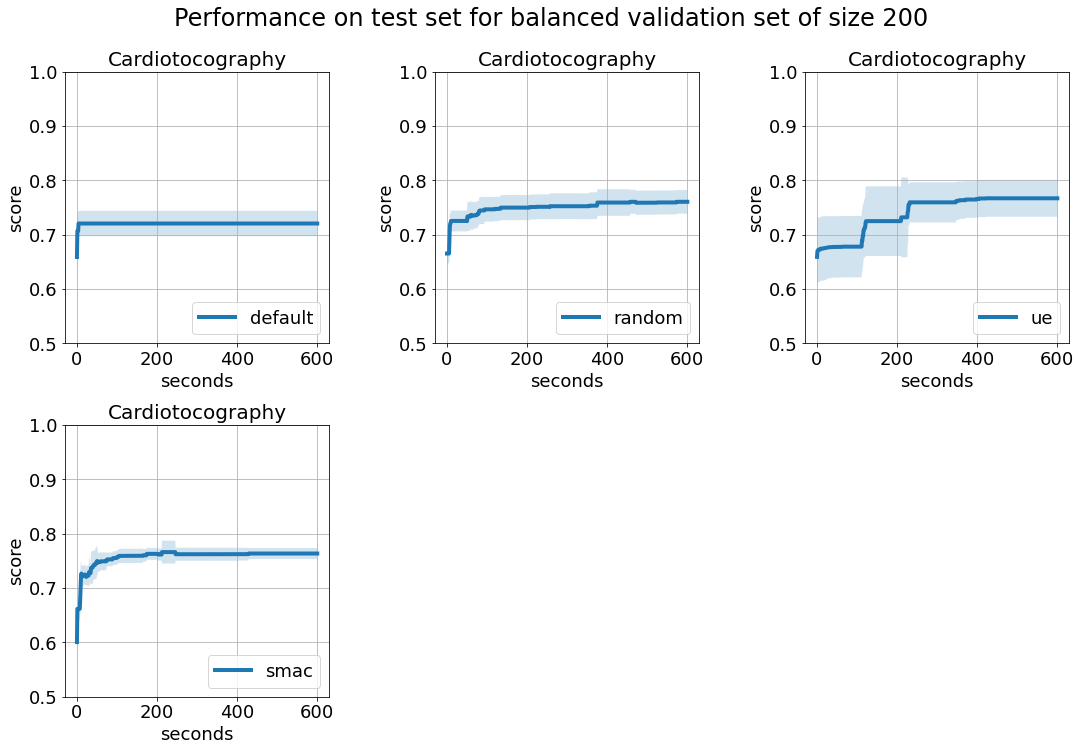

In [27]:
# Plot test set performance
plot_results_with_std_2(
    w0,
    h0,
    save_figures,
    figures_dir,
    results_processed_path,
    dataset_list,
    dataset_32,
    total_budget,
    search_strategy_list,
    validation_strategy_32,
    validation_size_32,
    'test'
)